In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)
np.random.seed(0)

In [2]:
data = pd.read_csv('data.txt',header=None,names=['x','y'],delim_whitespace=True)

In [3]:
data.head()

,x,y
0,-6.0,-164.160590
1,-5.8,90.739607
2,-5.6,-131.842090
3,-5.4,-178.428200
4,-5.2,-4.838565


<AxesSubplot:xlabel='x', ylabel='y'>

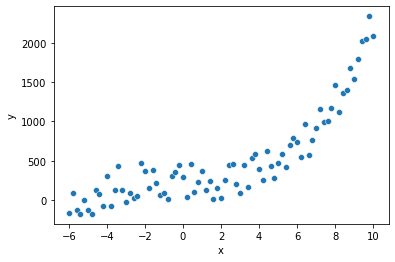

In [4]:
sns.scatterplot(x='x',y='y',data=data)

In [5]:
from sklearn.model_selection import KFold

In [6]:
X=data['x'].to_numpy()
Y=data['y'].to_numpy()
kfold = KFold(n_splits=10)
trainX=[]
trainY=[]
testX=[]
testY=[]

In [7]:
for train_index, test_index in kfold.split(X):
    trainX.append(X[train_index])
    testX.append(X[test_index])
    trainY.append(Y[train_index])
    testY.append(Y[test_index])

In [23]:
stdTrainX=[]
stdTestX=[]
stdTrainY=[]
stdTestY=[]
for i in range(10):
    stdTrainX.append((trainX[i]-np.mean(trainX[i],axis=0))/np.std(trainX[i],axis=0))
    stdTrainY.append((trainY[i]-np.mean(trainY[i],axis=0))/np.std(trainY[i],axis=0))
    stdTestX.append((testX[i]-np.mean(testX[i],axis=0))/np.std(testX[i],axis=0))
    stdTestY.append((testY[i]-np.mean(testY[i],axis=0))/np.std(testY[i],axis=0))

In [31]:
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [16]:
def computeCost(X,y,weights):
    n = len(y);
    predictions = X.dot(weights)
    sq_err = (predictions-y)**2;
    return np.mean(sq_err)

In [17]:
def computeStdCost(X,y,weights):
    n = len(y);
    predictions = X.dot(weights)
    sq_err = (predictions-y)**2;
    return np.std(sq_err)

In [58]:
def computeModels(degree):
    model_weights=[]
    for ind in range(10):
        polyFeat = PolynomialFeatures(degree=degree)
        Xtrain = polyFeat.fit_transform(stdTrainX[ind].reshape(-1,1))
        cmodel = SGDRegressor(max_iter=1500)
        cmodel.fit(Xtrain,stdTrainY[ind])
        weight=[]
        for item in (cmodel.coef_):
            weight.append(item)
        model_weights.append(weight)
    return model_weights

In [133]:
def computeErrorTerms(degree,nthModel,weight_list):
    polyFeat = PolynomialFeatures(degree=degree)
    modelNo = nthModel+1
    label = 'hypothesis'+str(modelNo)
    title = 'Hypothesis'+str(modelNo)
    plt.figure(figsize=(12,8))
    train_mean_err_list=[]
    test_mean_err_list=[]
    train_std_err_list=[]
    test_std_err_list=[]
    
    train_mean_y=[]
    test_mean_y=[]
    train_std_y=[]
    test_std_y=[]
    
    for i in range(10):
        weights = np.array(weight_list[i]).reshape((degree+1,1))
        Xtrain = polyFeat.fit_transform(stdTrainX[i].reshape(-1,1))
        Xtest = polyFeat.transform(stdTestX[i].reshape(-1,1))
        
        train_err = computeCost(Xtrain,stdTrainY[i].reshape(len(stdTrainY[i]),1),weights)
        test_err = computeCost(Xtest,stdTestY[i].reshape(len(stdTestY[i]),1),weights)
        train_std_err = computeStdCost(Xtrain,stdTrainY[i].reshape(len(stdTrainY[i]),1),weights)
        test_std_err = computeCost(Xtest,stdTestY[i].reshape(len(stdTestY[i]),1),weights)
        
        train_mean_y.append(np.mean(stdTrainY[i],axis=0))
        test_mean_y.append(np.mean(stdTestY[i],axis=0))
        train_std_y.append(np.std(stdTrainY[i],axis=0))
        test_std_y.append(np.std(stdTestY[i],axis=0))
        
        train_mean_err_list.append(train_err)
        test_mean_err_list.append(test_err)
        train_std_err_list.append(train_std_err/np.sqrt(10))
        test_std_err_list.append(test_std_err/np.sqrt(10))
        
        print("mean train error : ",train_err)
        print("std train error : ",train_std_err)
        print("mean test error : ",test_err)
        print("std test error : ",test_std_err)
        print("\n")
      
    print("\n\n")
    ind=[1,2,3,4,5,6,7,8,9,10]
    plt.subplot(2,2,1)
    plt.errorbar(x=ind,y=train_mean_y,yerr=train_mean_err_list, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel(label)
    plt.ylabel('train mean errorbar')
    plt.subplot(2,2,2)
    plt.errorbar(x=ind,y=train_std_y,yerr=train_std_err_list, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel(label)
    plt.ylabel('train std errorbar')
    plt.subplot(2,2,3)
    plt.errorbar(x=ind,y=test_mean_y,yerr=test_mean_err_list, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel(label)
    plt.ylabel('test mean errorbar')
    plt.subplot(2,2,4)
    plt.errorbar(x=ind,y=test_std_y,yerr=test_std_err_list,fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel(label)
    plt.ylabel('test std errorbar')
    plt.suptitle(title)
    plt.show()

    min_val = min(train_mean_err_list)
    min_ind = train_mean_err_list.index(min_val)
    print("min training error ",min_val," at index",min_ind+1,"for Hypothesis ",modelNo)
    plt.scatter(stdTrainX[min_ind],stdTrainY[min_ind])
    X_Poly = polyFeat.fit_transform(stdTrainX[min_ind].reshape(-1,1))
    pred = X_Poly.dot(np.array(weight_list[min_ind]).reshape(degree+1,1))
    plt.plot(stdTrainX[min_ind],pred,'r')
    

In [134]:
weight_list = computeModels(1)
print(weight_list)

[[0.0008273357899798413, 0.7880757558557213], [-0.0017056457794382724, 0.7975134838909648], [-0.0021146235675477756, 0.7945686957315042], [0.0006621296656622661, 0.7945531894332218], [0.0004192358030269369, 0.8063151929743914], [0.00040795435333209636, 0.8124938001137232], [-0.00033717348132932895, 0.81756478869155], [0.0007878320666401786, 0.8098214349821642], [0.000436086250808019, 0.7680694050570223], [-0.0007836121287517293, 0.7842869336017957]]


mean train error :  0.31878799125881696
std train error :  0.4940355064260621
mean test error :  1.0370257873257755
std test error :  1.0370257873257755


mean train error :  0.29941576534486525
std train error :  0.49051202548046596
mean test error :  1.4923890571719385
std test error :  1.4923890571719385


mean train error :  0.3005924048190467
std train error :  0.499607719402647
mean test error :  1.4389242917510061
std test error :  1.4389242917510061


mean train error :  0.3043012942426216
std train error :  0.4999449012960392
mean test error :  0.9112906773390305
std test error :  0.9112906773390305


mean train error :  0.2833166080468845
std train error :  0.4879204678146257
mean test error :  2.384768993953905
std test error :  2.384768993953905


mean train error :  0.2741338687398312
std train error :  0.45676027985620044
mean test error :  1.5262769261539866
std test error :  1.5262769261539866


mean train error :  0.26455492271805536
std train error :  0.43244576662395

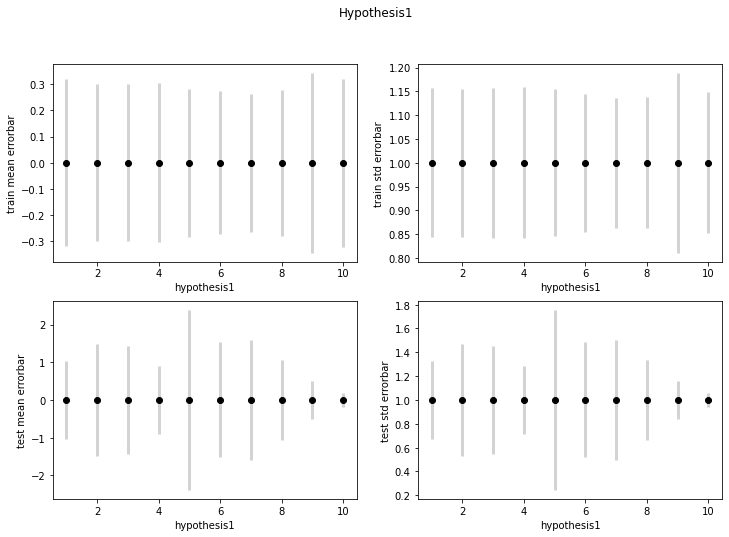

min training error  0.26455492271805536  at index 7 for Hypothesis  1


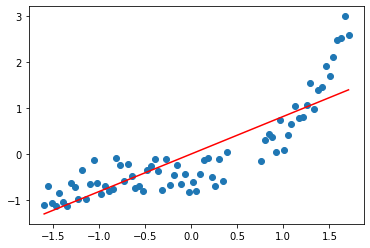

In [135]:
computeErrorTerms(1,0,weight_list)

In [136]:
weight_list = computeModels(3)
print(weight_list)

[[-0.19002737809666104, 0.2322456018771851, 0.41136462129115203, 0.3189986476095737], [-0.18835939598498558, 0.2783325693141973, 0.46952522054206386, 0.31736503949389094], [-0.17527307899545921, 0.24240508841552824, 0.45503739378296126, 0.36062570614745004], [-0.16795164319069547, 0.2307502439119121, 0.423804288086672, 0.3798443002759467], [-0.15488255871824316, 0.2130516602127478, 0.3590700282199932, 0.3964197006255183], [-0.16922044423922328, 0.21209027155030483, 0.34826179553382447, 0.379387756243859], [-0.16308023723806314, 0.18504449326046288, 0.30236970415618425, 0.3643552313792503], [-0.15411274663389687, 0.1478351006818576, 0.2635216096327421, 0.34288095926920775], [-0.13481237568035379, 0.10378315878372044, 0.23320437274873934, 0.33153511242469175], [-0.11087024716489721, 0.18445383777301524, 0.2511297130570745, 0.3536967024143961]]


mean train error :  0.12812752370501798
std train error :  0.1425128798356534
mean test error :  0.8840790419362219
std test error :  0.8840790419362219


mean train error :  0.11329005457974894
std train error :  0.12736172688692426
mean test error :  2.1643433191882036
std test error :  2.1643433191882036


mean train error :  0.10943613718550868
std train error :  0.1220765644433369
mean test error :  2.3918935502516963
std test error :  2.3918935502516963


mean train error :  0.10863355063887949
std train error :  0.11680032320292234
mean test error :  1.3464709423968308
std test error :  1.3464709423968308


mean train error :  0.10624087655445903
std train error :  0.12165053804432921
mean test error :  2.923592941602173
std test error :  2.923592941602173


mean train error :  0.10819478556600454
std train error :  0.11647007028540367
mean test error :  1.3368584291639114
std test error :  1.3368584291639114


mean train error :  0.105581296215934
std train error :  0.115608142

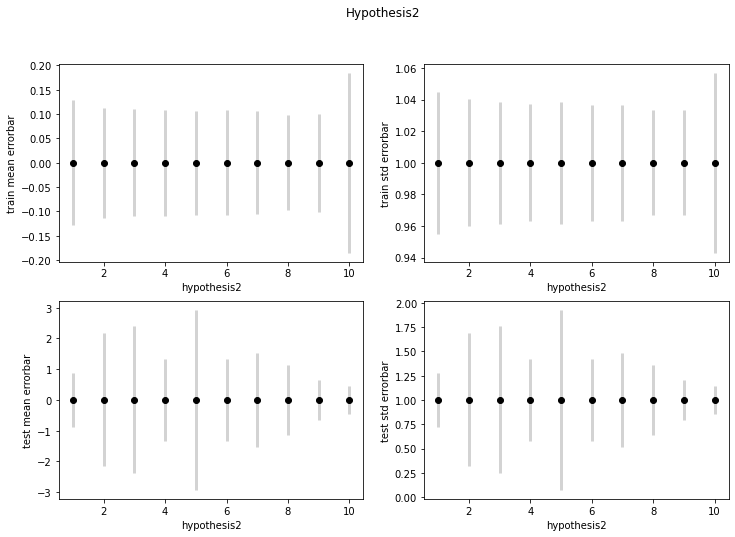

min training error  0.09746078009095642  at index 8 for Hypothesis  2


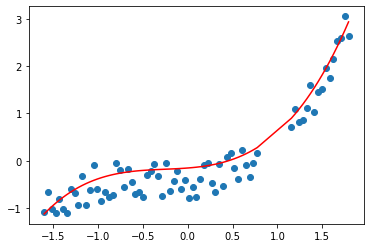

In [137]:
computeErrorTerms(3,1,weight_list)

In [138]:
weight_list = computeModels(5)
print(weight_list)

[[-0.17664171606865367, 0.3009030905808413, 0.08890692733797216, 0.21642188833365603, 0.1519570271204813, 0.0345318551053933], [-0.15502580721877351, 0.22608843078673108, 0.05473076844635187, 0.187912984569319, 0.19484327955104505, 0.07195403934392236], [-0.16125056017066422, 0.26927540012155493, 0.08467730959852938, 0.22305390882205964, 0.18820035674675117, 0.06471650392661105], [-0.15717909270037664, 0.24090947004089866, 0.07656113574998312, 0.2122534762063361, 0.18692951296863175, 0.08014861736780944], [-0.1558599693905216, 0.258206632841638, 0.04800098396504786, 0.2214898921522382, 0.16934246082213597, 0.06338578730164746], [-0.15681613934559696, 0.22725593443563305, 0.04754222458419371, 0.17515538232126124, 0.16155747672125417, 0.09216821556428573], [-0.1625466534682076, 0.21159927553736857, 0.06511393517314537, 0.17806390132718078, 0.12552777317453268, 0.06888121299501523], [-0.15194823936071233, 0.1649947236082529, 0.02692369814965856, 0.14282997257008606, 0.10839808413852457, 0

mean train error :  0.11505182005171408
std train error :  0.1406940157714498
mean test error :  0.9441803377269733
std test error :  0.9441803377269733


mean train error :  0.11213449896491258
std train error :  0.1365946817378206
mean test error :  2.1778735575468104
std test error :  2.1778735575468104


mean train error :  0.10162170177166391
std train error :  0.12035014248635752
mean test error :  2.641315459603792
std test error :  2.641315459603792


mean train error :  0.10157660235058992
std train error :  0.1184814806616557
mean test error :  1.3407315862762417
std test error :  1.3407315862762417


mean train error :  0.08876570753274102
std train error :  0.10212358676933442
mean test error :  3.0247994127385085
std test error :  3.0247994127385085


mean train error :  0.10334014003697346
std train error :  0.12796450805832757
mean test error :  1.3214370463434626
std test error :  1.3214370463434626


mean train error :  0.1007724601171237
std train error :  0.116841820

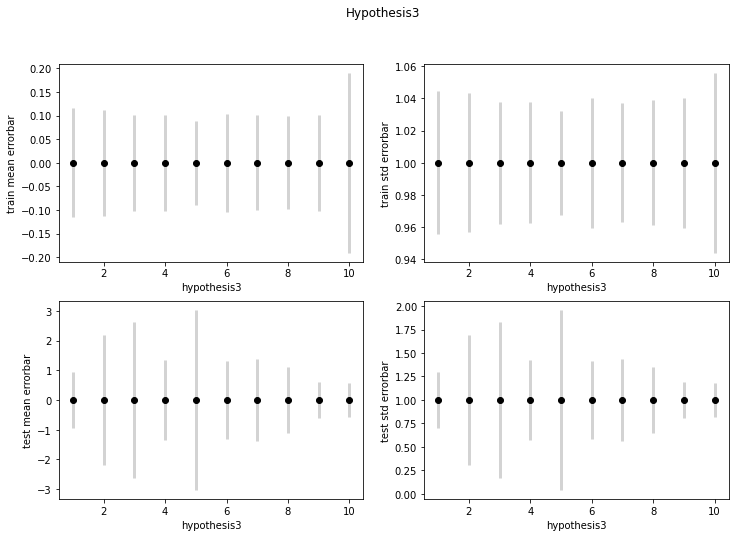

min training error  0.08876570753274102  at index 5 for Hypothesis  3


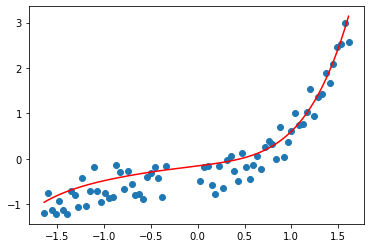

In [139]:
computeErrorTerms(5,2,weight_list)

In [140]:
weight_list = computeModels(50)
print(weight_list)

[[44641103152.25437, 169797538564.73233, 58323456112.512, 347610237201.6085, 58970498693.952225, 741600112744.1824, 26878688242.75345, 1676170702680.07, -100324177414.66905, 3926912681899.1616, -499456123983.6978, 9386941969030.61, -1674296372202.7932, 22692481296992.15, -5073304518442.593, 55197155876375.42, -14895532335787.402, 134645494117060.55, -43390108643660.71, 328543554031012.1, -126439415587510.78, 800008366019769.9, -369420600229558.2, 1939162907959561.5, -1082187162008430.4, 4665355682957121.0, -3176194998766715.5, 1.1099198307293826e+16, -9332103116638964.0, 2.5978699352711724e+16, -2.7429959207072784e+16, 5.937059032639174e+16, -8.061811025016496e+16, 1.3086145517633958e+17, -2.368455140301594e+17, 2.72009693393519e+17, -6.954153026574552e+17, 5.077152849557123e+17, -2.0404828865065306e+18, 7.336414460674028e+17, -5.983048042970066e+18, 1.775309544306592e+17, -1.7531612381186406e+19, -4.654248195819306e+18, -5.133937563801515e+19, -2.725323152854912e+19, -1.50256627726691

mean train error :  1.1600832029251264e+64
std train error :  6.905813300073305e+64
mean test error :  5.340101790532327e+60
std test error :  5.340101790532327e+60


mean train error :  3.2145262403716862e+72
std train error :  2.4729729675443497e+73
mean test error :  1.5453629626749645e+64
std test error :  1.5453629626749645e+64


mean train error :  7.504356933974808e+66
std train error :  5.797406269851683e+67
mean test error :  1.9809991364808067e+61
std test error :  1.9809991364808067e+61


mean train error :  2.6080739596678603e+60
std train error :  2.0156482227757209e+61
mean test error :  1.6569090262344537e+57
std test error :  1.6569090262344537e+57


mean train error :  5.841767395805465e+58
std train error :  4.353181900747325e+59
mean test error :  5.0297646418216986e+56
std test error :  5.0297646418216986e+56


mean train error :  1.9889489873172065e+60
std train error :  1.546395049171354e+61
mean test error :  9.465155060715236e+57
std test error :  9.465155060715

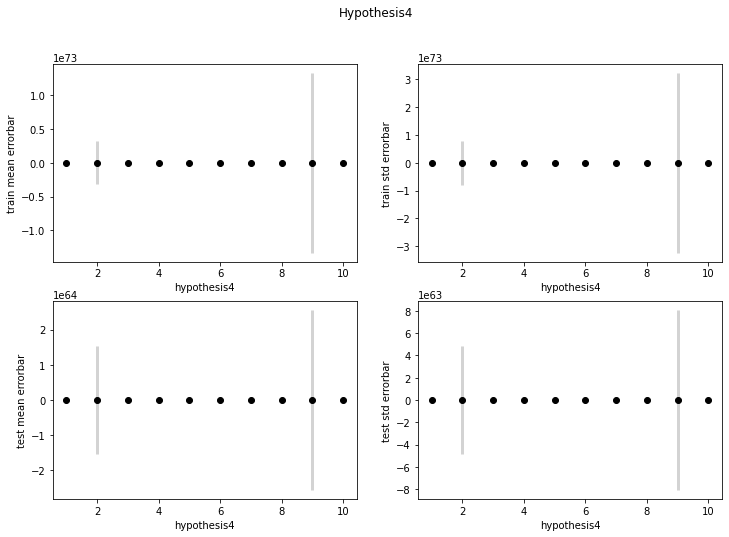

min training error  5.841767395805465e+58  at index 5 for Hypothesis  4


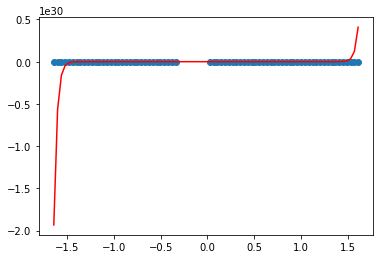

In [141]:
computeErrorTerms(50,3,weight_list)